# Introduction:

Here we present the results for using the Adaptive Dropout approach to prune "nodes" rather than "weights" of a fully connected layer in a CNN. 

We decide the Dropout dynamically for every input in the original Adaptive Dropout approach instead of having a fixed Dropout. The input from previous layers decide the Dropout probability for the subsequent layer, by using a "Standout Network" to determine the probabilities. In the original paper, [Adaptive dropout for training deep neural networks](https://papers.nips.cc/paper/5032-adaptive-dropout-for-training-deep-neural-networks.pdf) (by J ba et al) the authors have used this approach to build Auto Encoders, here we use the same approach but to prune nodes i.e. we prune the nodes with minimum retention probability.

Unlike the original paper on [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks](https://arxiv.org/pdf/1803.03635.pdf) (by Frankle, et al) we prune the nodes and not the weights. Also we do not re-initialize the weights to their value which was at the beginning, we continue to use the same values for weights which was learned even after pruning and continue to train the network.

The code for using Adaptive Dropout approach to build a classifier can be found [here](https://github.com/DuttaAbhigyan/Adaptive-Dropout/blob/master/Adaptive_Dropout%20with%20PyTorch.ipynb).


## Running Environment:

Since we will be using Google Colab to perform our experiments, we first set up the environment in Google Colab, namely we perform PyTorch installation and mount the Google Drive.

In [1]:
# Installation of PyTorch
!pip3 install torch torchvision

"""# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')"""

"# Mounting Google Drive\nfrom google.colab import drive\ndrive.mount('/content/gdrive')"

## Imports:
Now we make all the necessary imports required to perform and visualize our experiment.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Using GPU for our program:
Since, we want to use Google Colab's GPU we will use the following command to convert all tensors to CUDA type, as advised in this <a href="https://discuss.pytorch.org/t/solved-make-sure-that-pytorch-using-gpu-to-compute/4870"> Make Sure That Pytorch Using GPU To Compute</a>. You want to skip this part if you are working on CPU.

In [0]:
if(torch.cuda.is_available()):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

## Loading Datasets:

We load the famous and standard <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a> dataset for our program. The MNIST dataset contains 50000 (50k) training examples and 10000 (10k) examples for testing. We split the Training Set into a Training dataset and a Validation dataset. We also keep the code for loading  and <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion MNIST</a> dataset.

In [0]:
# Dataset Loading

# Smaller batch size causes slower loading of the entire dataset, but occupies less memory

batch_train = 500   # Smaller batch size helps in faster convergence by introducing randomness
batch_val = 500
batch_test = 512

validation_set = 0.2 # This is the ratio of the training set used for validation

# Create Train and Validation Data Loaders
"""train_set = torchvision.datasets.MNIST(
            root = '../data/MNIST',
            train = True,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))"""


train_set = torchvision.datasets.FashionMNIST(
            root = '../data/FMNIST',
            train = True,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))

val_size = int(validation_set*len(train_set))
train_size = len(train_set) - val_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_train)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_val)

# Create the Test Loader
test_set = torchvision.datasets.MNIST(
            root = '../data/MNIST',
            train = False,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))


"""test_set = torchvision.datasets.FashionMNIST(
            root = '../data/FMNIST',
            train = False,
            download = True,
            transform = transforms.Compose([transforms.ToTensor()]))"""

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_test)

# To be used for training
data_loaders = {}
data_loaders['Train'] = train_loader
data_loaders['Validation'] = val_loader

## Sampling Operation:
Now we perform the sampling operation for the dropout. We pass a Tensor of __Retention Probabilities__ i.e the probability with which a node will be retained, and the function returns a Tensor of the same size as Retenetion Probabilities which we call the Mask. The Mask Tensor contains **0** and __1__ values where 1 indicates a node is retained and 0 indicates a node is dropped.

In [0]:
def sample_mask(p):
    r"""Given a Tensor of probabilities 'p' this function
       will sample a mask nd return the mask (the probabilities are retention probabilities)"""
    #Random Sampling
    uniform = torch.Tensor(p.size()).uniform_(0, 1)
    #Setting Mask
    mask = uniform < p
    #Setting proper Data Type
    return mask.float()

## Pruning Mask:

This function returns a mask which will effectively prune nodes with lowest average **Retention Probability**. It does this by returning a mask of $0$'s and $1$'s which will effectively prune the Neural Network.

In [0]:
def calculate_pruning(p_sum, ratio):
    r"""Given a Tensor of probability sums (of multiple batches) and a ratio
        this function will return a mask. First we calculate the average probability
        sum over the entire training set and set a number of nodes according to the ratio
        to 0 and the rest is set to 1. the number of nodes is calculated as ratio*number_nodes"""
    size_2d = p_sum.size()
    # Flatten the tensor to (number_of_nodes,) shape
    p_sum = torch.sum(p_sum, 0)
    size_1d = p_sum.size()[0]
    mask = p_sum.clone().detach()
    mask.requires_grad = False
    # Calculate the number of nodes to be pruned
    prune_size = int(ratio*size_1d)
    print(prune_size)
    for i in range(prune_size):
        v,i = torch.min(mask,0)
        mask[i] = float('inf')
    # Set the mask
    mask[mask == float('inf')] = 0
    mask[mask != 0] = 1
    return mask.float()

## Pruning Standout Layer:

We define the Pruning Standout Layer here (as per Algorithm 2 in the original paper) introducing Adaptive Dropout, but with a slight mdification. The modification being that the output is now multpilied with a pruning mask so that effetively **Retention Probability** is $0$ for certain nodes as decided in the above function. It inherits from nn.Module class of PyTorch. The Standout Layer can easily be converted to a standard Dropout layer by setting paramaeter $\alpha=0$ and $\beta=0.5$ for a Dropout rate of $0.5$.

In [0]:
class Pruning_Standout(nn.Module):
    r"""Defining the Standout Operation as per Algorithm 2"""
    def __init__(self, previousWeights, alpha, beta, nonlinearity):
        super(Pruning_Standout, self).__init__()
        self.pi = previousWeights
        self.alpha = alpha                 
        self.beta = beta
        self.nonlinearity = nonlinearity # Sigmoid used in the original paper
    
    # Forward propagation via the layer
    def forward(self, inputs, outputs, pruneMask):
        self.p = self.nonlinearity(self.alpha*inputs.matmul(self.pi.t()) + self.beta)
        # Neural Net effectively pruned
        if(self.training):
            self.mask = sample_mask(self.p)
            return self.mask*outputs*pruneMask, self.p
        else:
            return self.p*outputs*pruneMask, self.p


## Hyperparameter Choices :

Now we perform some experiments and plot the results to show some comparattive results. As mentioned before and iterated over again our method performs pruning in the following way as compared to the original paper.

- We pruned nodes of the fully connected layer rather than connection weights.
- The choice of nodes to be pruned is made by the Adaptive Dropout algorithm and the nodes with the lowest retention probabilities are trimmed.

There are various Hyperaparameters we can vary during the training process namely:

- Architecture of the classifier
- Dataset used
- Learning Algorithm
- Learning Rate
- Number of Epochs
- Batch Size
- Method of pruning
- Pruning Period

We perform our experiments with the following choice of Hyperparameters:

- **Architecture of the classifier** - The architecture of the classifier is a CNN whose structure is described in preceding cells.

- **Dataset used** - The Dataset used is the Fashion MNIST dataset since it is more challenging the MNIST dataset.

- **Learning Algorithm** - We use a SGD optimizer along with momentum for a fixed number of epochs followed by Adam optimizer for another fixed number of epochs for finer learning.

- **Learning Rate** - We fix the learning rate of the SGD optimizer at $0.01$ with momentum $0.9$.

- **Number of Epochs** - The Number of epochs is fixed at $200$ for the SGD optimizer with momentum and $100$ epochs for Adam optimizer.

- **Batch Size** - The batch size is fixed at $500$ to provide learning the required randomness and not hit saddle points while still maintaining a good Gradient direction.

- **Method of pruning** - The pruning of the nodes in the final layer is done as per the following algorithm, the hyperparameter here is the $pruning_{ratio}$.

$$ratio \leftarrow 0$$     
$$nodes_{pruned} = nodes_{total}*(ratio + (1-ratio)*pruning_{ratio}$$
$$ratio = ratio + (1-ratio)*pruning_{ratio}$$

- **Pruning Period** - The pruning period is the number of epochs after which we want the Pruning to be done.



### Experiments:

We mainly deal with the experiment of changing CNN architecture, changing dataset, changing loss function, changing method of pruning and changing the period of pruning and plot its effects as a comparative study.

## Neural Network Model:

In this section we introduce two simple CNN models for the putpose of illustration for implementing the Adaptive Dropout algorithm. In both the cases for the convolutional layers we use the following scheme:

$784$ $\rightarrow$ $24$ filters with $(5,5)$ stride and padding $=2$ $\rightarrow$ $(2,2)$ pooling with stride $=2$ $\rightarrow$ $48$ filters with $(5,5)$ stride and padding $=2$ $\rightarrow$ $(2,2)$ pooling with stride $=2$ $\rightarrow$ $64$ filters with $(5,5)$ stride and padding $=2$ $\rightarrow$ $(2,2)$ pooling with stride $=2$ $\rightarrow$ Flatten to $576$ nodes.

1. In the first case we use a CNN with only a single fully with $256$ nodes connected layer at the end, the Adaptive Dropout will be applied to this fully connected layer.

2. In the second case we use a CNN with two fully connected layer, each with $256$ nodes, at the end, the Adaptive Dropout will be applied to this two fully connected layers (this will be illustrated in another Notebook).

In [0]:
class Neural_Net(nn.Module):

    def __init__(self):
        super(Neural_Net, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1,24,5, padding = 2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(24,48,5, padding = 2)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv3 = nn.Conv2d(48,64,5, padding = 2)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(576,256)
        self.std1 = Pruning_Standout(self.fc1.weight, 0.5, 0.5, nn.Sigmoid()) # Standout Layer 1
        self.fc2 = nn.Linear(256, 256)
        self.std2 = Pruning_Standout(self.fc2.weight, 0.5, 0.5, nn.Sigmoid()) # Standout Layer 2
        self.final = nn.Linear(256,10)

    def forward(self, x, pruneMask):
        # Convolutional Layers Forward Propagation
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 576)
        
        # Fully Connected Layers Forward Propagation
        inputs1 = x.clone().detach()
        x = F.relu(self.fc1(x))
        inputs2 = x.clone().detach()  # NOTE: We have to use the inputs of previous layer for Standout
        x,p= self.std1(inputs1, x, pruneMask)
        #x = F.relu(self.fc2(x))       # Comment out if you want to use single FC layer
        #x = self.std2(inputs2, x)     # Comment out if you want to use single FC layer
        x = self.final(x)
        return x, p

## Training Function:

Now we train the Neural Network with the loss function as the Binary Cross Entropy Loss, using a very simple (but unflexible) scheme, we use SGD with Momentum for the first 50 epochs and then the Adam optimizer for the next 50 epochs for a total of 100 epochs. The training algorithm shows the Training Loss, Training Accuracy, Validation Loss and Validation Accuracy for each epochs. It returns a list with average loss and accuracy for Training and Validation phases for the purpose of plotting it.

In [0]:
# Function to train the model
def train(epochs1, epochs2, data_loaders, prune_ratio, prune_period):
    global pruneMask
    ratio = 0
    lossT = []
    lossCV = []
    accCV = []
    accT = []
    pruneMask = 1
    # Running with the SGD with momentum optimizer
    for i in range(epochs1):
        
        # Calculate mask for pruning the Neural Net
        if(i%prune_period == 0 and i != 0):
            pruneMask = calculate_pruning(p_sum, ratio)
            ratio = ratio + (1-ratio)*prune_ratio             # Update the ratio as percentage of the ramianing nodes
            print(ratio)
            
        print('Epoch: ' + str(i+1))
        for phase in ['Train', 'Validation']:
            
            #Total predictions and Correct predictions set to 0
            total = 0
            correct = 0

            #Running loss  set to 0
            running_loss = 0.0

            #Probability sum over entire batch set to 0
            p_sum = torch.zeros(500, 256)

            # Number of minibatches 
            # NOTE: Even though the batch size might not be uniform,
            # we approximate it as all batches are of equal size
            k = len(data_loaders[phase])
            
            if phase == 'Train':
                net.train(True)  # Set model to training mode
            else:
                net.train(False) # Set model to validation mode

            # Iterate through the batches             
            for data in data_loaders[phase]:
                images,labels = data
                if(torch.cuda.is_available()):
                    labels = labels.long().cuda()
                    images = images.cuda()
                else:
                    labels = labels.long()
                outputs,p = net.forward(images, pruneMask)

                p_sum += p/k

                loss = criterion(outputs, labels)
                optimizer1.zero_grad()

                # Backprop + optimize only if in training phase
                if phase == 'Train':
                    loss.backward()
                    # Update the weights
                    optimizer1.step()
                running_loss += loss.item()

                #Check predictions
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)                  # length of each batch added
                correct += (predicted == labels).sum().item()

        
            epoch_loss = running_loss/k
            epoch_acc = correct/total
            if(phase == 'Train'):
                lossT.append(epoch_loss)
                accT.append(epoch_acc)
            elif(phase == 'Validation'):
                lossCV.append(epoch_loss)
                accCV.append(epoch_acc)

            # Print for showing  loss and accuracy                          
            print('Loss for ' + phase + ' is ' + str(epoch_loss))
            print('Accuracy for ' + phase + ' is ' + str(epoch_acc)) 
        print()
        
    # Running with the Adam optimizer
    for i in range(epochs2):
        
        # Calculate mask for pruning the Neural Net
        if((i+epochs1)%prune_period == 0 and (i+epochs1) != 0):
            pruneMask = calculate_pruning(p_sum, ratio)
            ratio = ratio + (1-ratio)*prune_ratio             # Update the ratio as percentage of the remianing nodes
            print(ratio)
        
        print('Epoch: ' + str(i+epochs1+1))
        for phase in ['Train', 'Validation']:
            
            #Total predictions and Correct predictions set to 0
            total = 0
            correct = 0

            #Running loss  set to 0
            running_loss = 0.0

            #Probability sum over entire batch set to 0
            p_sum = torch.zeros(500, 256)

            # Number of minibatches 
            # NOTE: Even though the batch size might not be uniform,
            # we approximate it as all batches are of equal size
            k = len(data_loaders[phase])
            
            if phase == 'Train':
                net.train(True)  # Set model to training mode
            else:
                net.train(False) # Set model to validation mode

            # Iterate through the batches             
            for data in data_loaders[phase]:
                images,labels = data
                if(torch.cuda.is_available()):
                    labels = labels.long().cuda()
                    images = images.cuda()
                else:
                    labels = labels.long()
                outputs,p = net.forward(images, pruneMask)

                p_sum += p/k

                loss = criterion(outputs, labels)
                optimizer2.zero_grad()

                # Backprop + optimize only if in training phase
                if phase == 'Train':
                    loss.backward()
                    # Update the weights
                    optimizer2.step()
                running_loss += loss.item()

                #Check predictions
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)                  # length of each batch added
                correct += (predicted == labels).sum().item()

        
            epoch_loss = running_loss/k
            epoch_acc = correct/total
            if(phase == 'Train'):
                lossT.append(epoch_loss)
                accT.append(epoch_acc)
            elif(phase == 'Validation'):
                lossCV.append(epoch_loss)
                accCV.append(epoch_acc)

            # Print for showing  loss and accuracy                          
            print('Loss for ' + phase + ' is ' + str(epoch_loss))
            print('Accuracy for ' + phase + ' is ' + str(epoch_acc)) 
        print()
    return lossT, lossCV, accT, accCV


## Performing Experiments:

We perform the following experiments:

- We vary the $pruning_{ratio}$ as $0.05$, $0.1$, $0.25$, $0.5$.
- We vary the $prune_{period}$ as $10$, $15$, $25$

In [42]:
# Initializing the Neural Net and all the Hyperparamters for the experiments
pruning_ratio = [0.05, 0.1, 0.25, 0.4]
prune_period = [10, 15, 25]
criterion = nn.CrossEntropyLoss()

epochs1 = 200
epochs2 = 100
results = {}

for i in pruning_ratio:
    for j in prune_period:
        results[(i,j)] = {}
        net = None
        net = Neural_Net()
        optimizer1 = optim.SGD(net.parameters(), lr = 0.01, momentum= 0.9)
        optimizer2 = optim.Adam(net.parameters(), lr = 0.001)
        if(torch.cuda.is_available()):
            net.cuda()

        lossT, lossCV, accT, accCV = train(epochs1, epochs2, data_loaders, i, j)
        results[(i,j)].update({'lossT':lossT, 'lossCV':lossCV, 'accT':accT, 'accCV':accCV})

Epoch: 1
Loss for Train is 2.12484942873319
Accuracy for Train is 0.20847916666666666
Loss for Validation is 1.2990138083696365
Accuracy for Validation is 0.49933333333333335

Epoch: 2
Loss for Train is 0.8658286308248838
Accuracy for Train is 0.6703333333333333
Loss for Validation is 0.7136465832591057
Accuracy for Validation is 0.7388333333333333

Epoch: 3
Loss for Train is 0.6763677926113209
Accuracy for Train is 0.7469166666666667
Loss for Validation is 0.6469776853919029
Accuracy for Validation is 0.7634166666666666

Epoch: 4
Loss for Train is 0.6093302586426338
Accuracy for Train is 0.7754583333333334
Loss for Validation is 0.5858055129647255
Accuracy for Validation is 0.7850833333333334

Epoch: 5
Loss for Train is 0.5624794249112407
Accuracy for Train is 0.7937083333333333
Loss for Validation is 0.5355444339414438
Accuracy for Validation is 0.8010833333333334

Epoch: 6
Loss for Train is 0.5272675575688481
Accuracy for Train is 0.8067083333333334
Loss for Validation is 0.50059025

## Plotting:

We now plot the loss and accuracy of our training, on the Training and Validation set.

In [0]:
%matplotlib inline

Plotting Constant Pruning Ratio v/s Varying Pruning Period


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


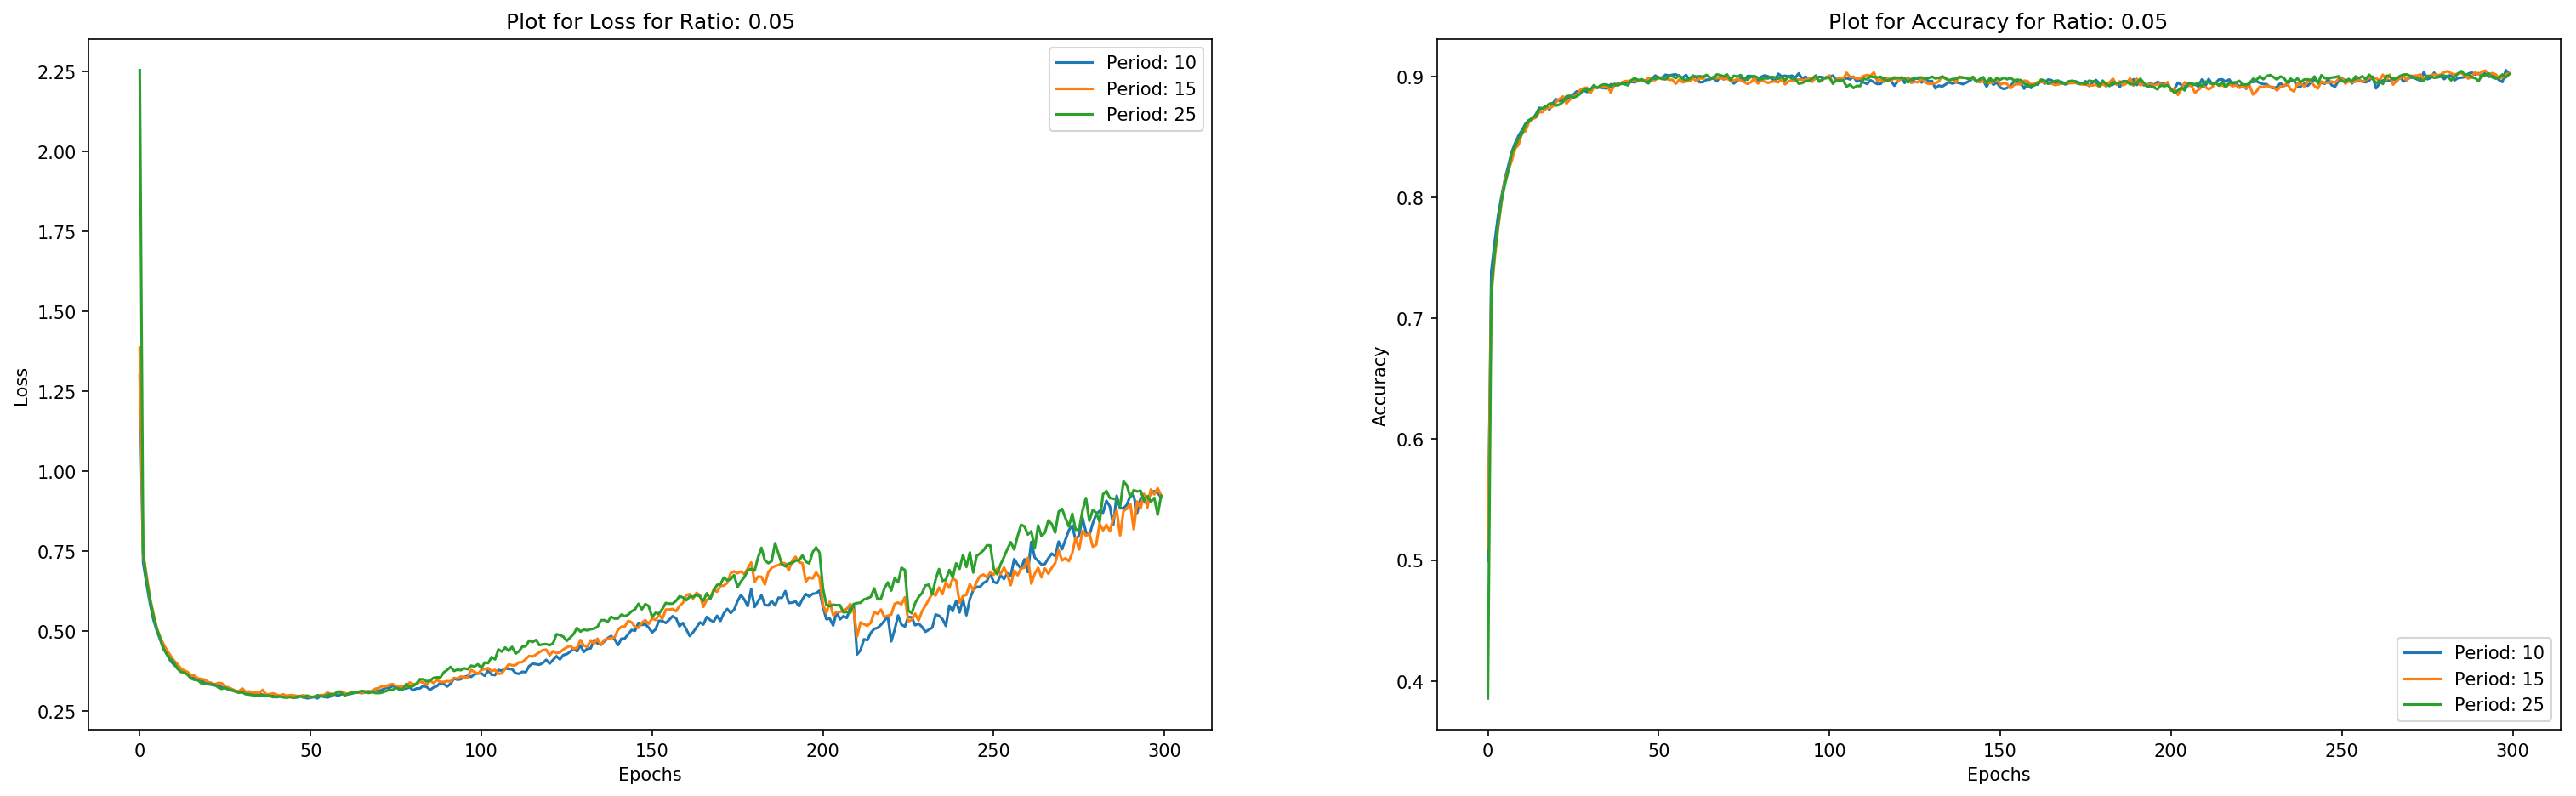

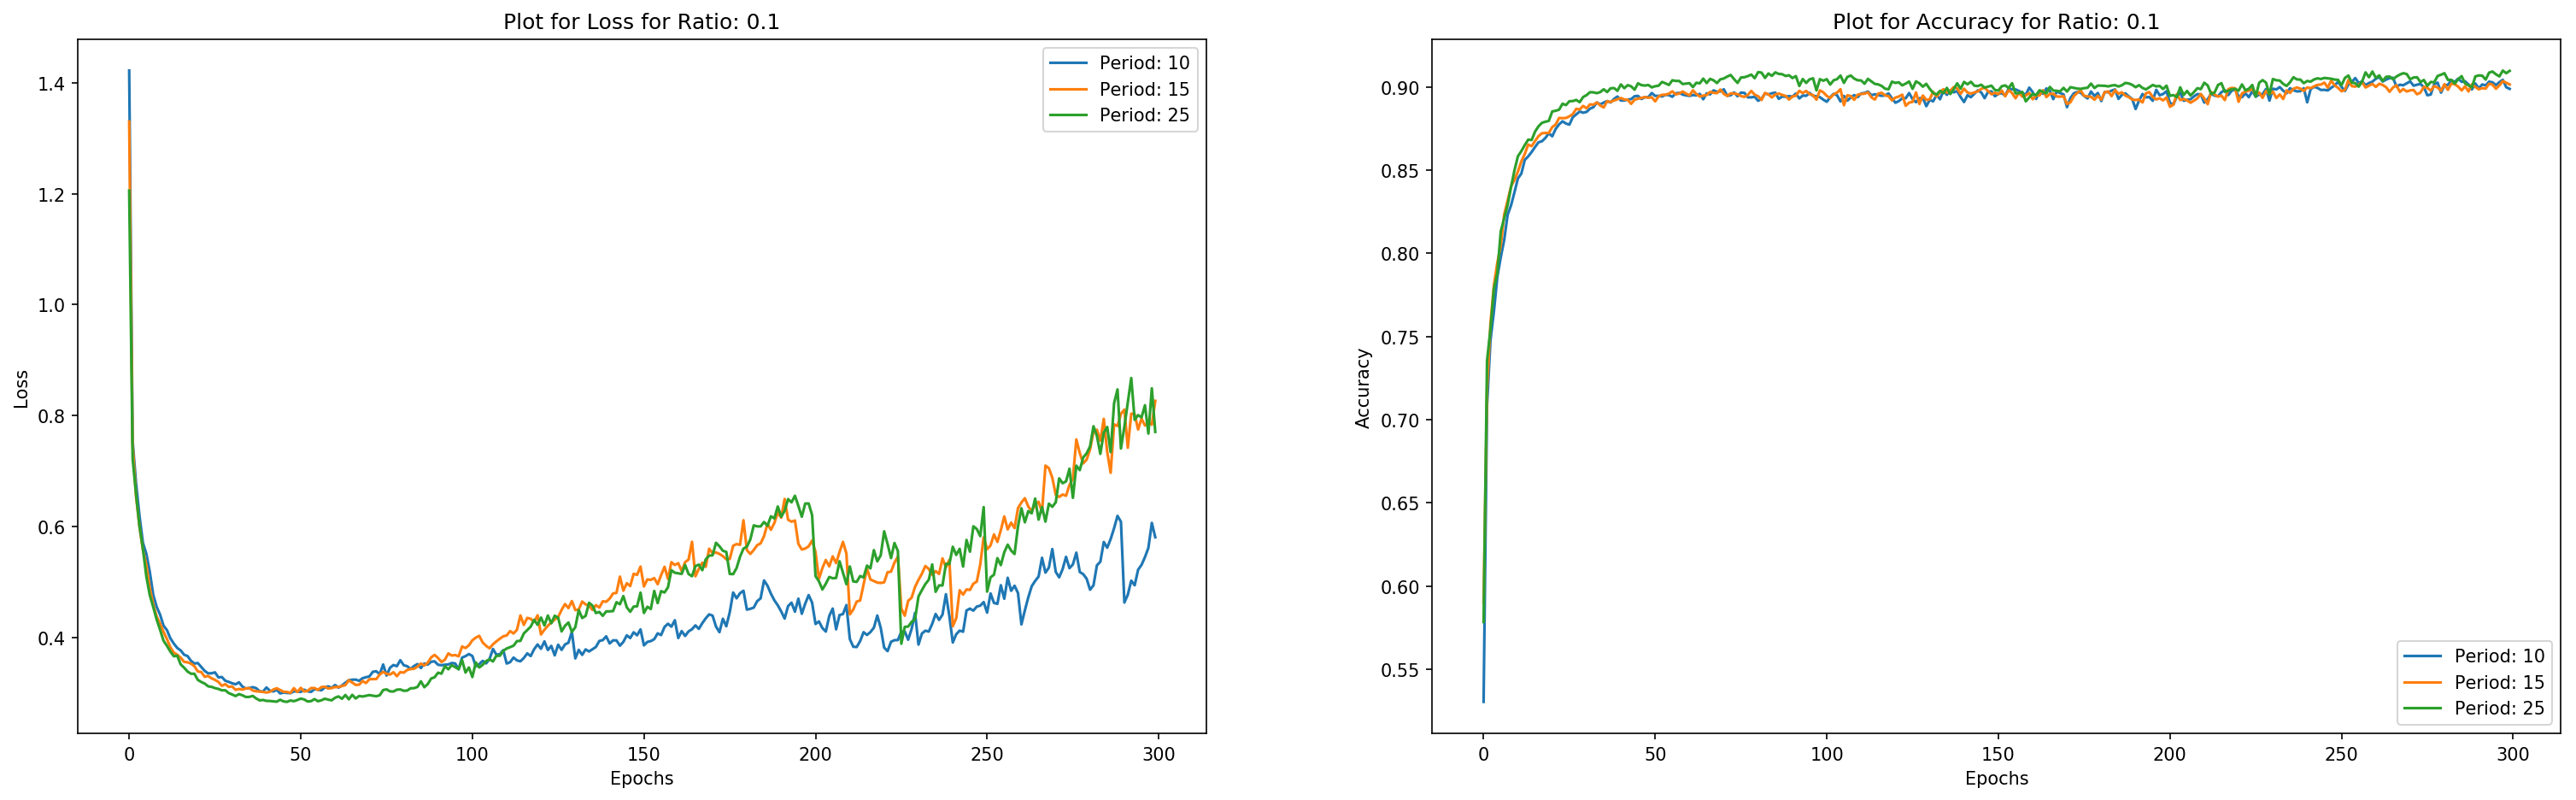

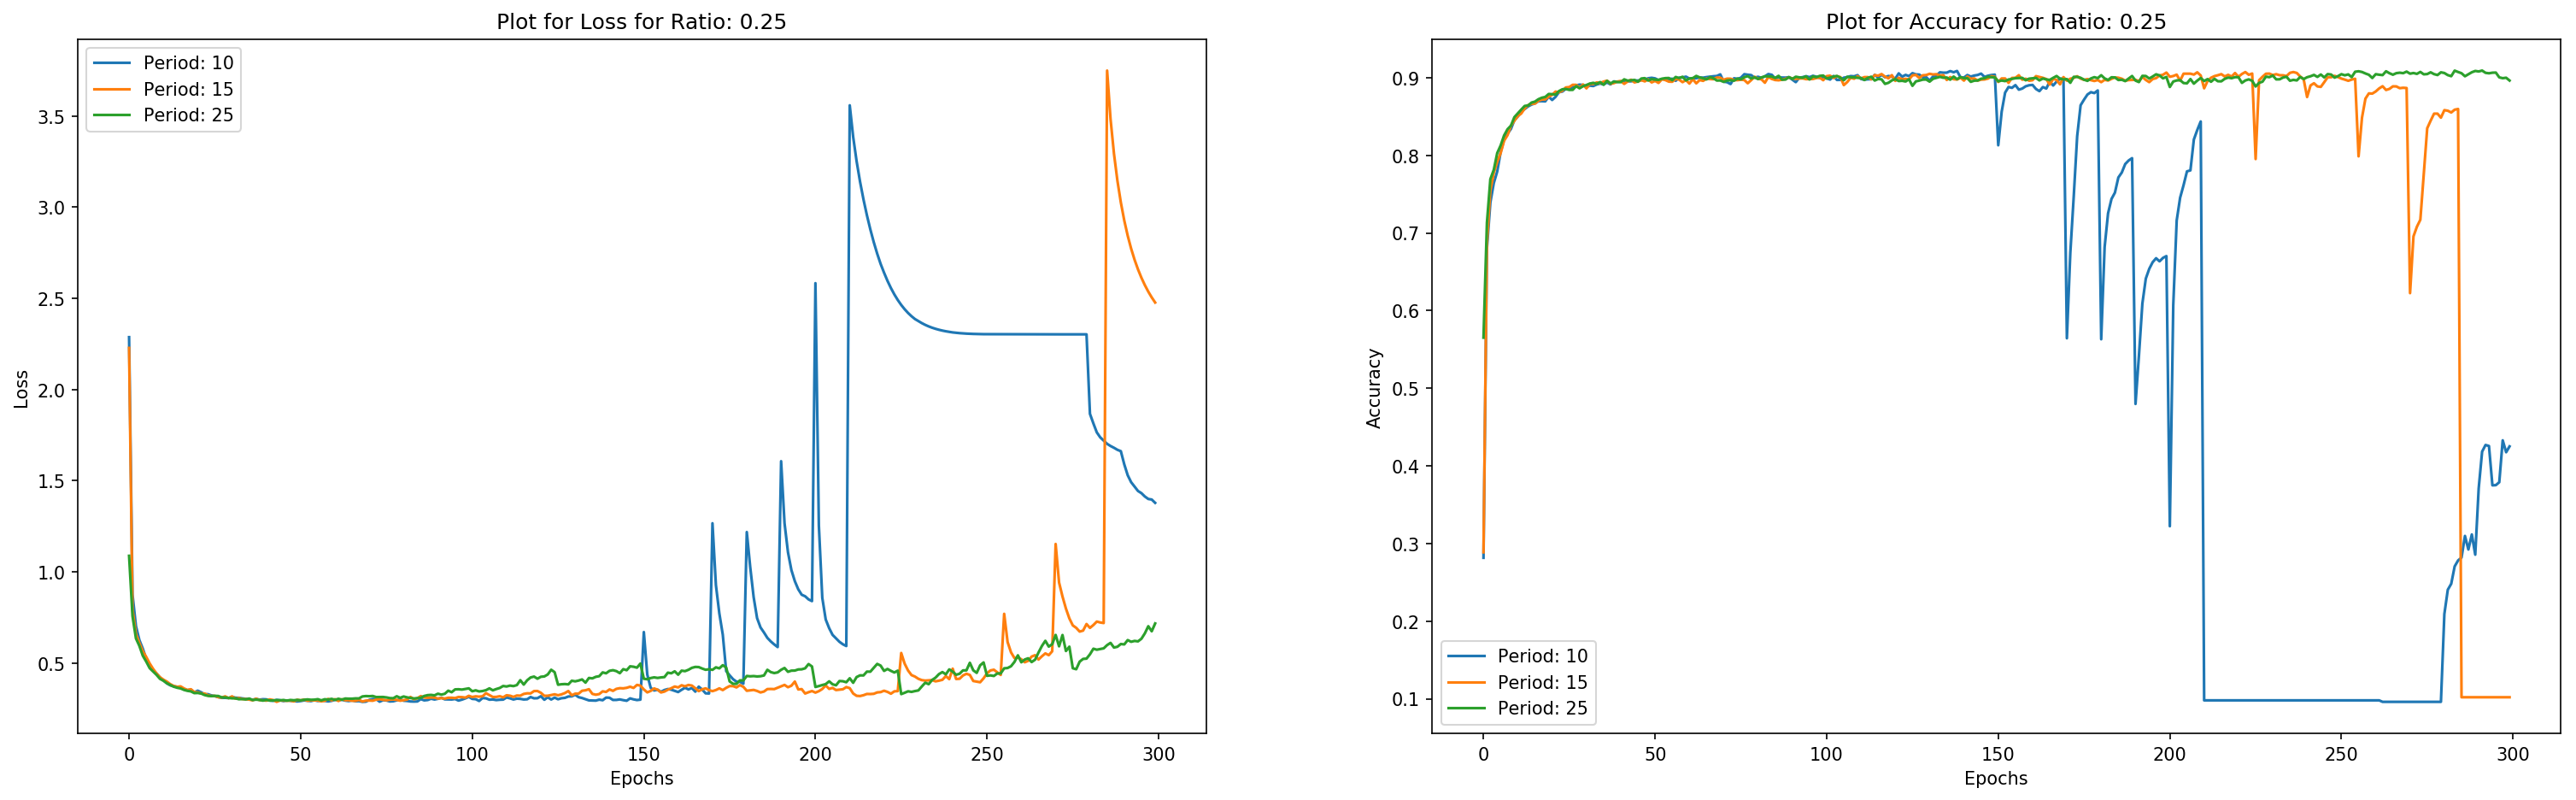

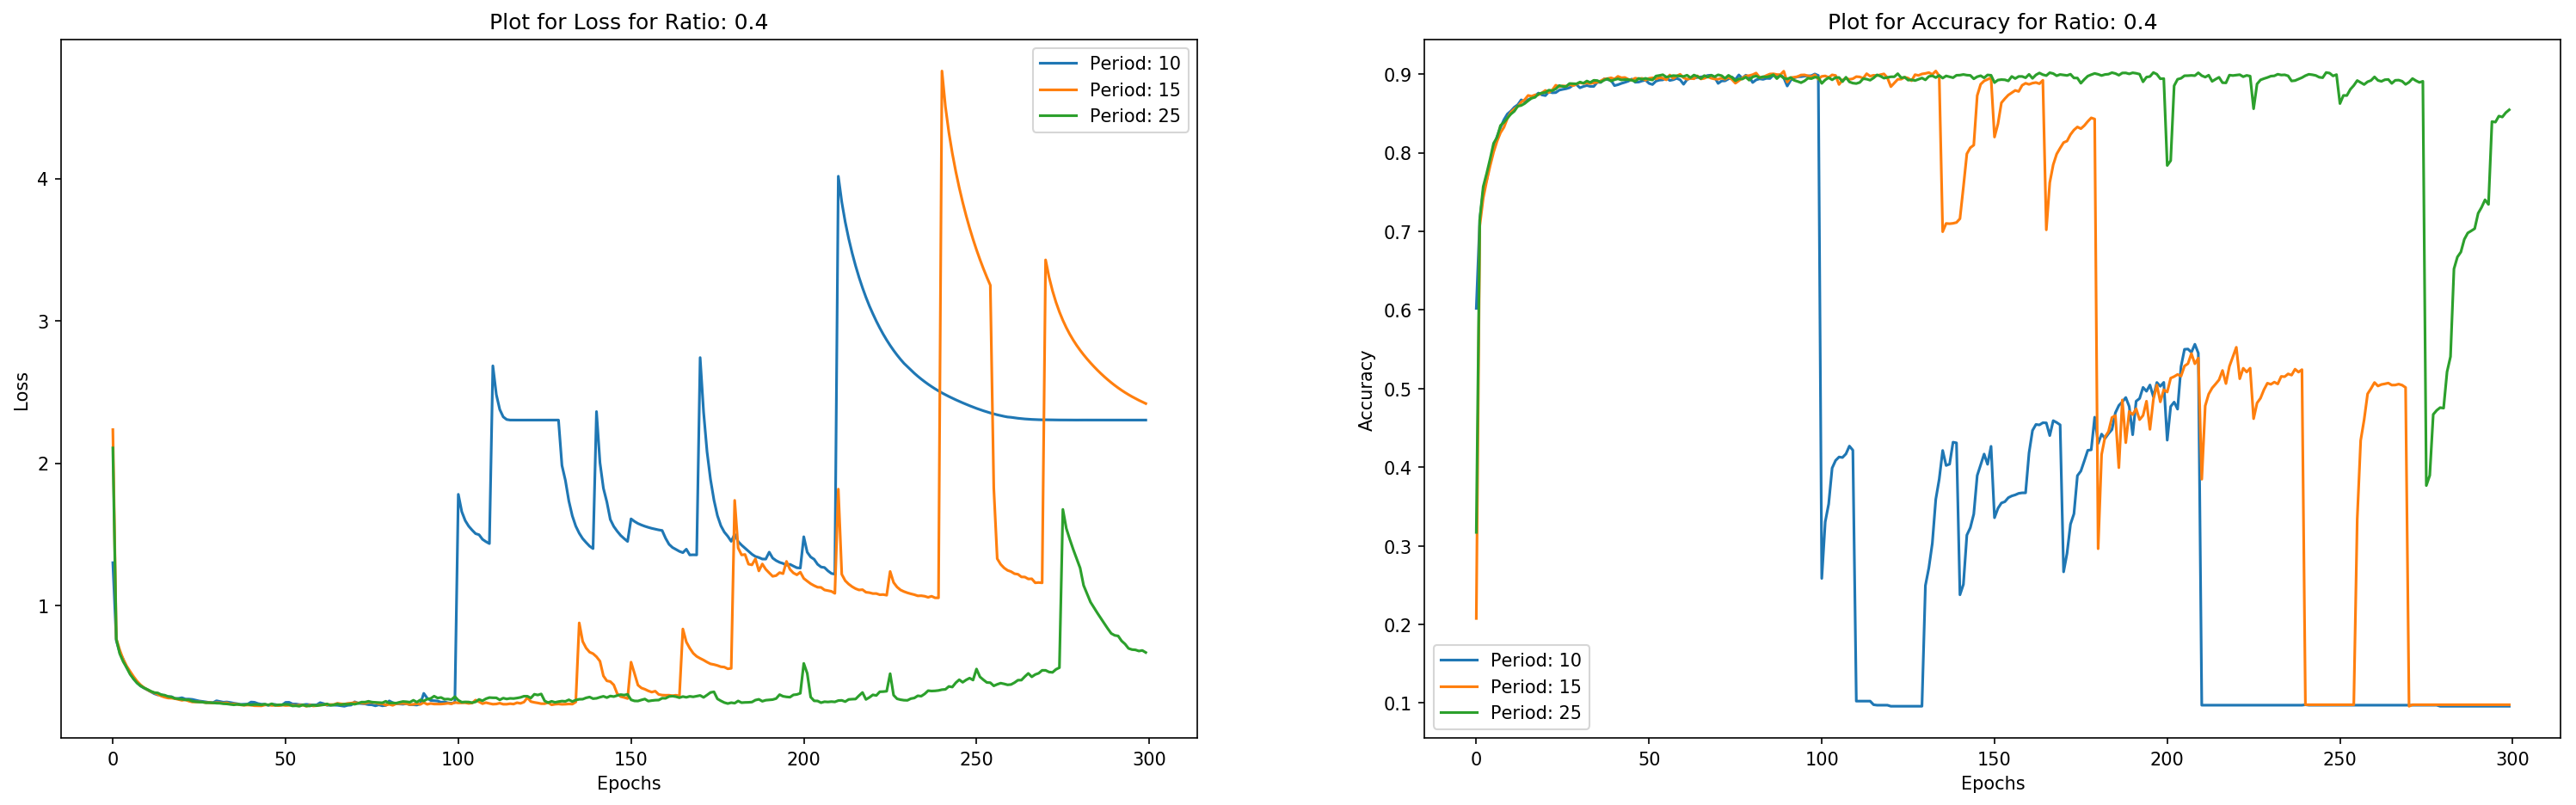



Plotting Varying Pruning Ratio v/s Constant Pruning Period




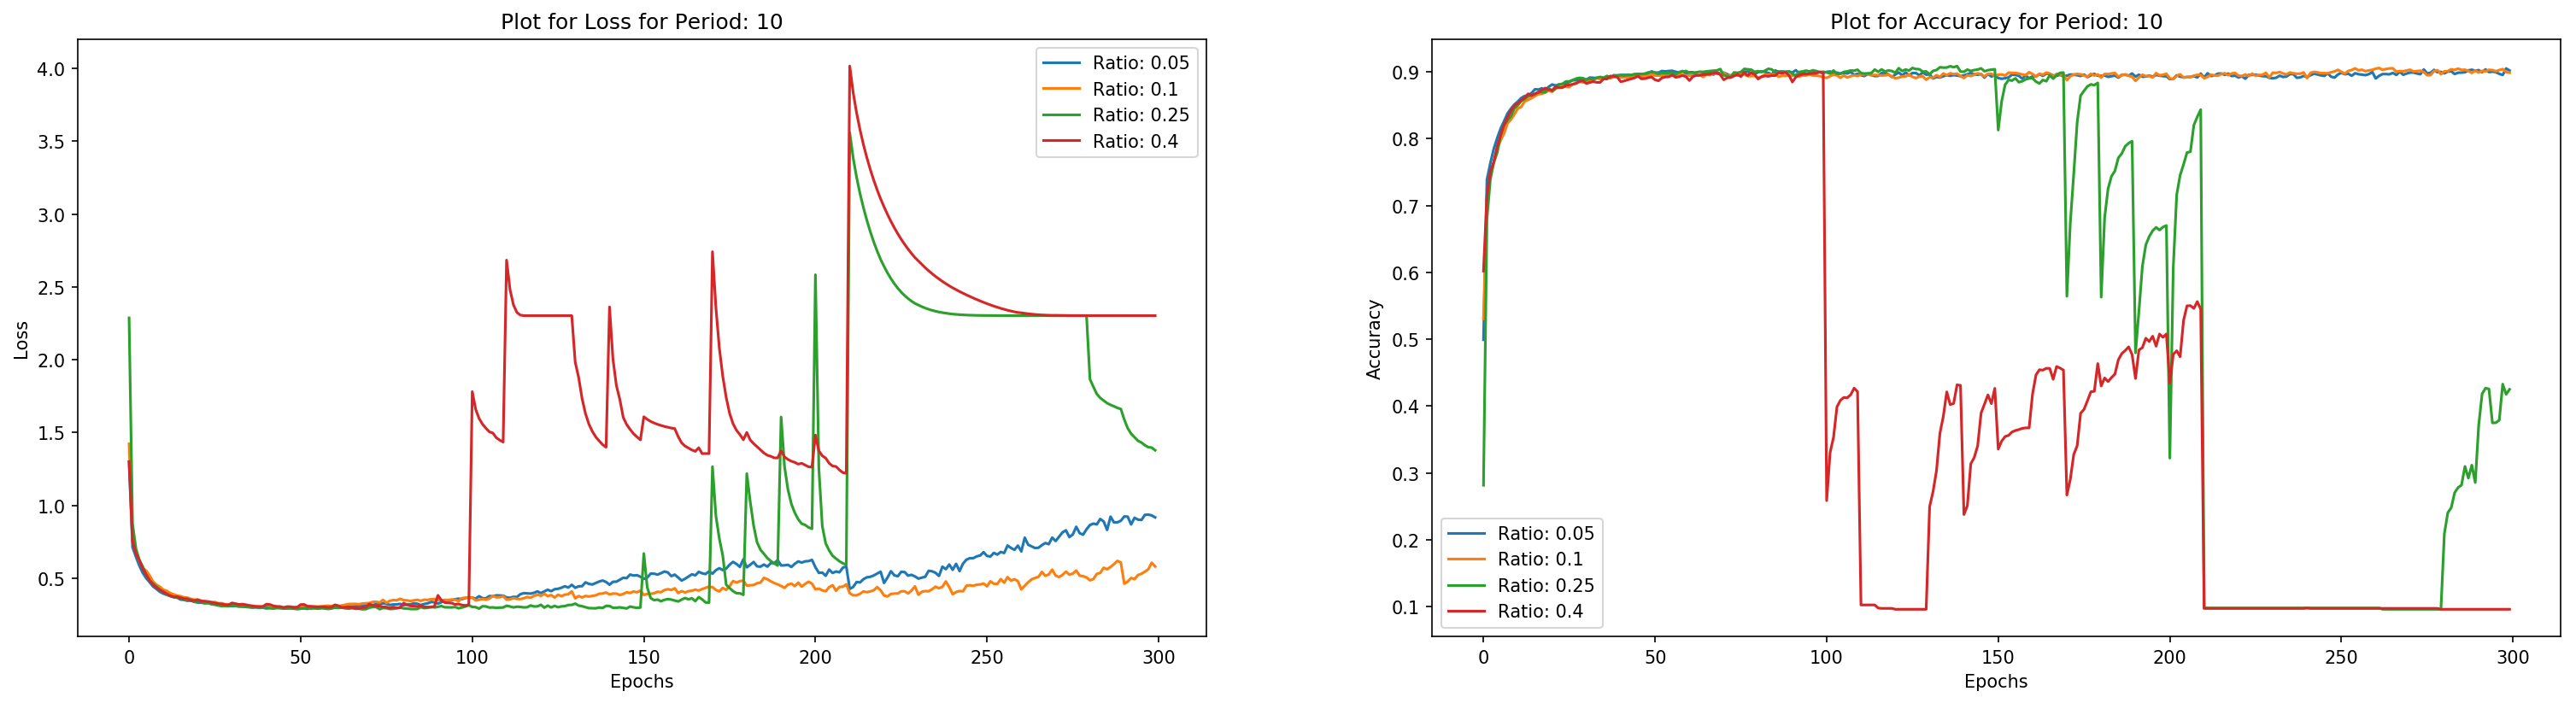

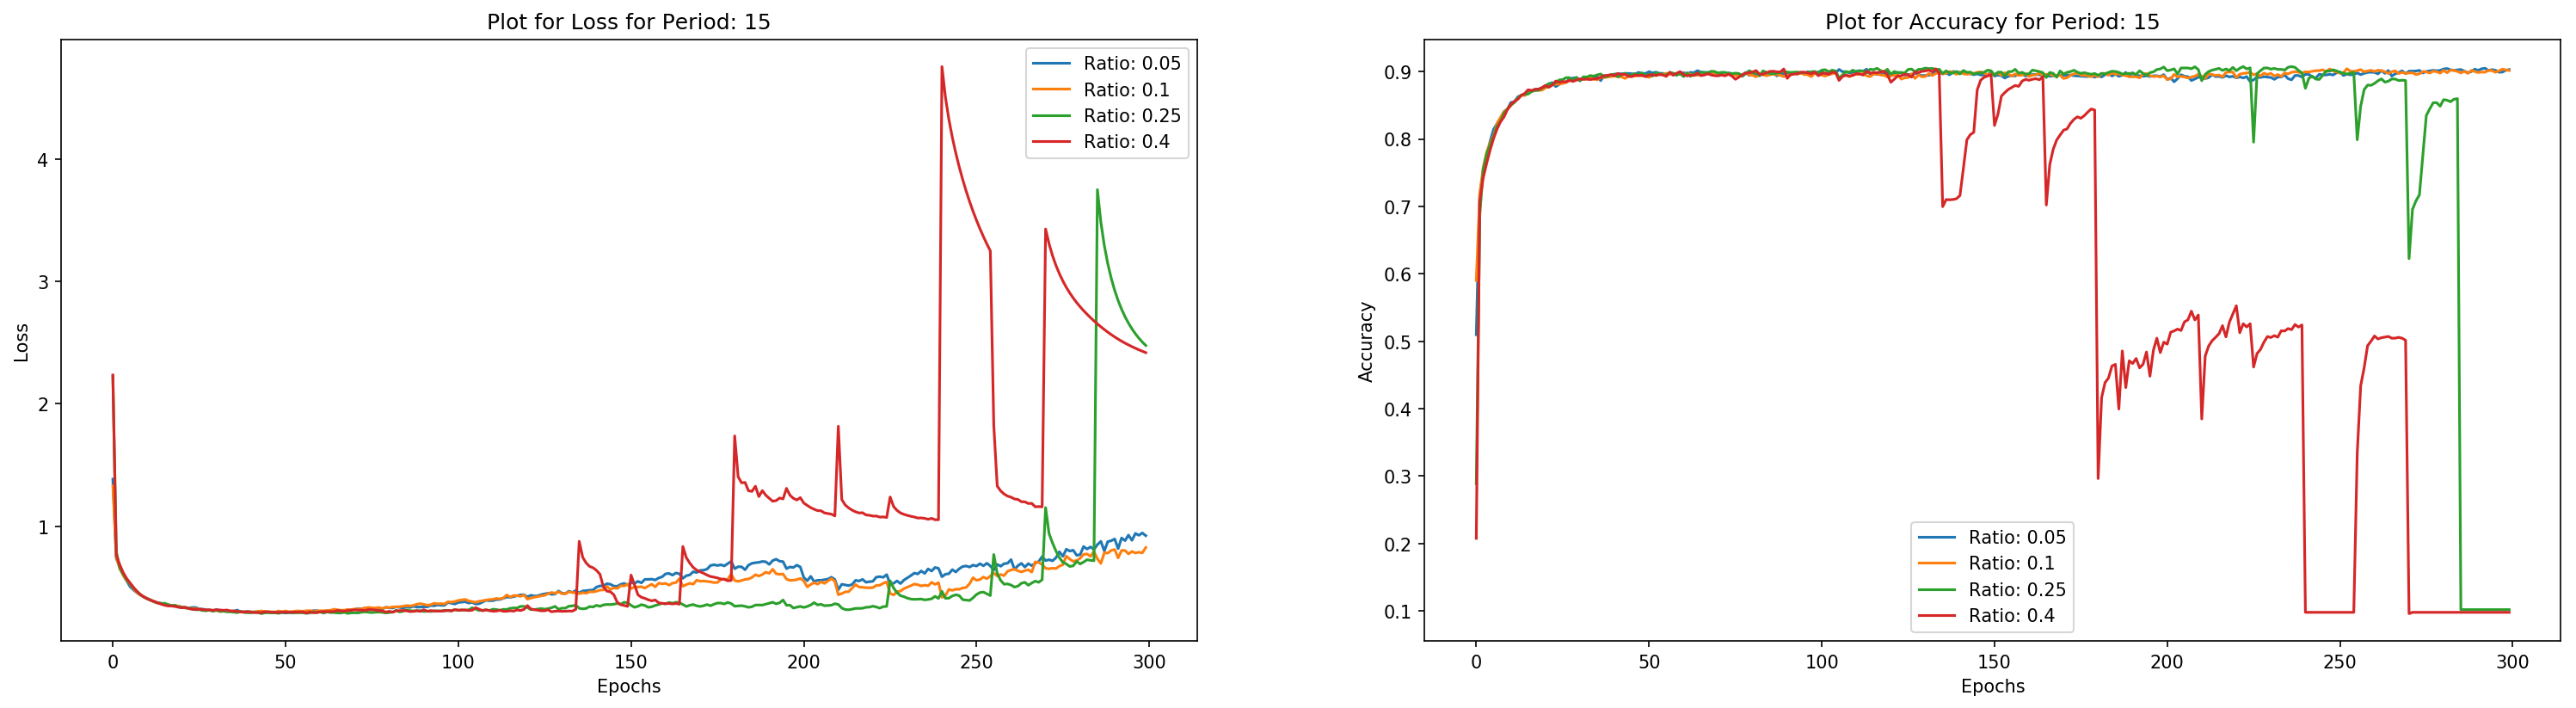

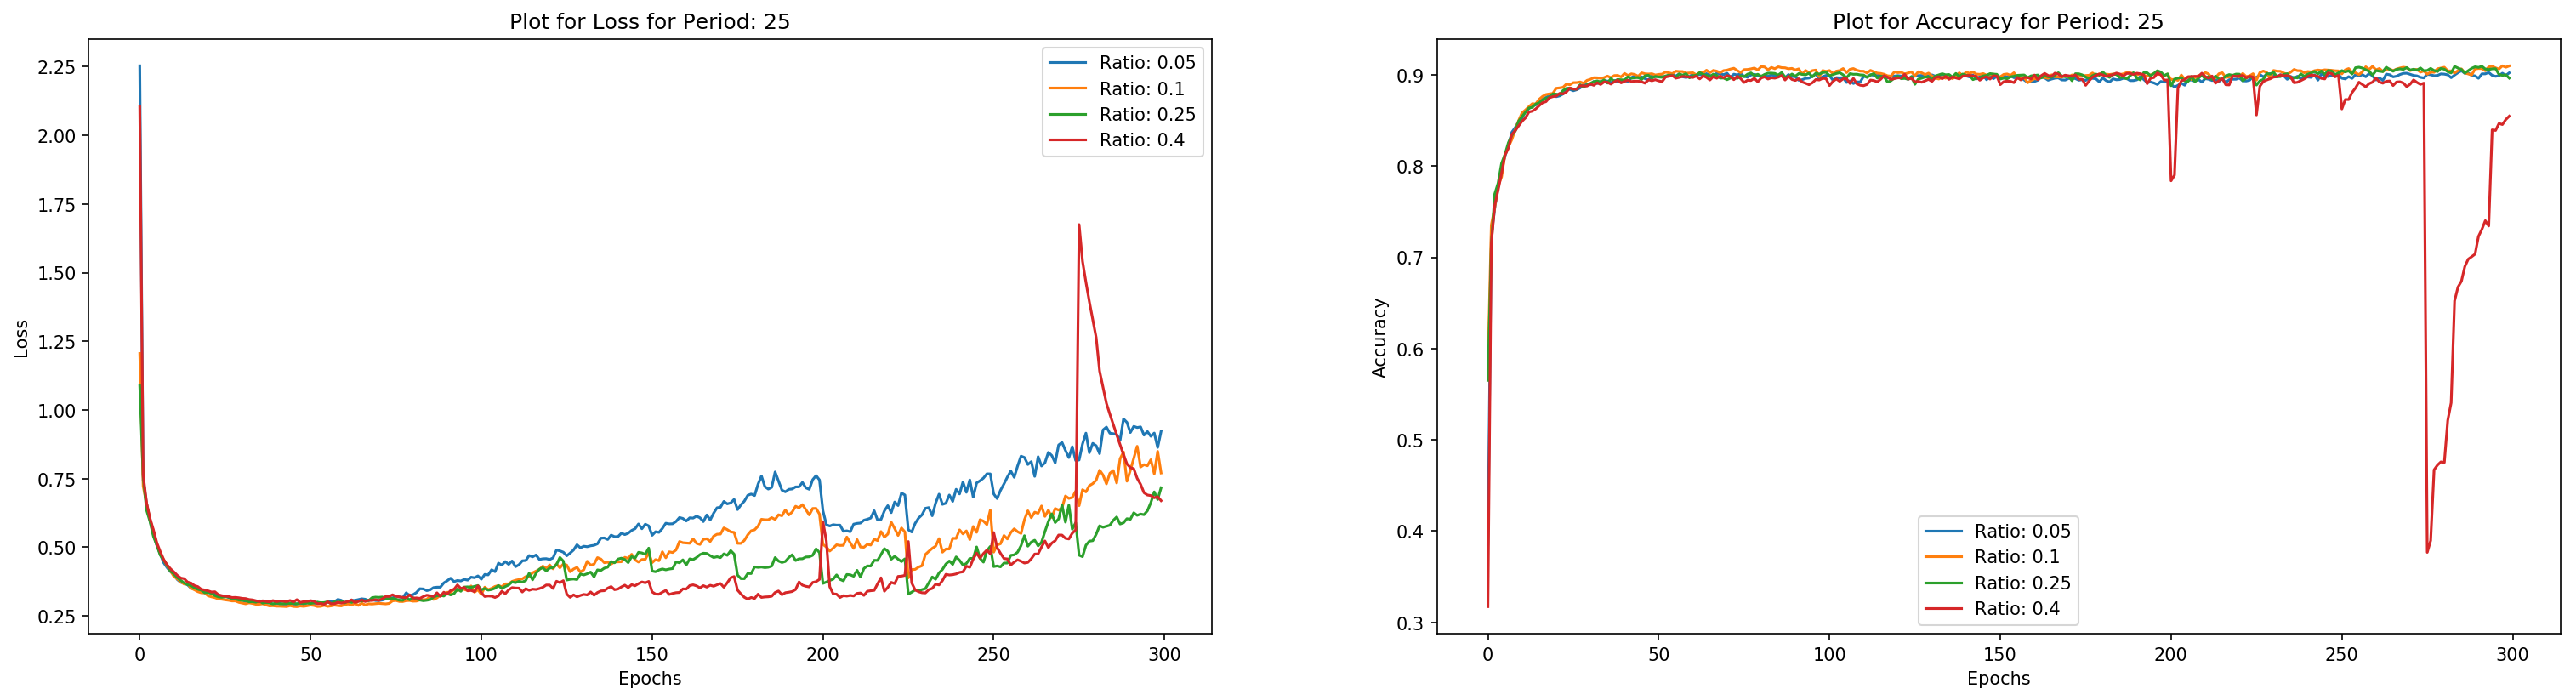

In [50]:
epochs = list(range(epochs1+epochs2))

print("Plotting Constant Pruning Ratio v/s Varying Pruning Period")

for i in pruning_ratio:
    index = pruning_ratio.index(i)
    fig=plt.figure(figsize=(25, 33), dpi= 150, facecolor='w', edgecolor='k')
    for j in prune_period:
        # Plotting Loss
        plt.subplot(4, 2, 2*index+1)
        plt.plot(epochs, results[(i,j)]['lossCV'], label = 'Period: ' + str(j))
        plt.title('Plot for Loss for Ratio: ' + str(i))
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(loc='best')

        #Plotting Accuracy
        plt.subplot(4, 2, 2*index+2)
        plt.plot(epochs, results[(i,j)]['accCV'], label = 'Period: ' + str(j))
        plt.title('Plot for Accuracy for Ratio: ' + str(i))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(loc='best')
    plt.show()
    print()
    print()
   
plt.close()

    
print("Plotting Varying Pruning Ratio v/s Constant Pruning Period")

print()
print()

for i in prune_period:
    index = prune_period.index(i)
    fig=plt.figure(figsize=(25, 21), dpi= 150, facecolor='w', edgecolor='k')
    for j in pruning_ratio:
        # Plotting Loss
        plt.subplot(3, 2, 2*index+1)
        plt.plot(epochs, results[(j,i)]['lossCV'], label = 'Ratio: ' + str(j))
        plt.title('Plot for Loss for Period: ' + str(i))
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(loc='best')

        #Plotting Accuracy
        plt.subplot(3, 2, 2*index+2)
        plt.plot(epochs, results[(j,i)]['accCV'], label = 'Ratio: ' + str(j))
        plt.title('Plot for Accuracy for Period: ' + str(i))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(loc='best')
    plt.show()
    print()
    print()
